In [1]:
import os
import pandas as pd
import re
from tqdm import tqdm

basic_info_df = pd.read_csv('data/parkings_info.csv')
basic_info_df['lat_long'] = list(zip(basic_info_df['latitude'], basic_info_df['longitude']))

In [6]:
from graph_utils import build_graph

target_park = '电影大厦'
target_area, adj, target_map, nks, kns = build_graph(basic_info_df, target_park)
target_park_basic_info = basic_info_df.loc[basic_info_df.parking_name == target_park].iloc[0]

seqs_raw = build_area_seqs(target_area, start='2016-10-01', end='2016-11-01')
# normalization
seqs_normal = seqs_raw/seqs_raw.max()

In [3]:
def get_nodes_features(area_df):
    node_f = area_df[['total_space','monthly_fee','building_type']]
    node_f['total_space'] = node_f.total_space/node_f.total_space.max()
    node_f['monthly_fee'] = node_f.monthly_fee/node_f.monthly_fee.max()
    building_type_oneHot = pd.get_dummies(node_f['building_type'])
    node_f = node_f.drop('building_type',axis = 1)
    node_f = node_f.join(building_type_oneHot)
    return node_f

In [4]:
node_f = get_nodes_features(target_area)

<ipython-input-3-6246592cf25e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_f['total_space'] = node_f.total_space/node_f.total_space.max()
<ipython-input-3-6246592cf25e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_f['monthly_fee'] = node_f.monthly_fee/node_f.monthly_fee.max()


In [5]:
from IPython.display import Image, display
from datetime import date, timedelta
import pandas as pd
import numpy as np

def build_area_seqs(target_area, start='2016-08-01', end='2017-01-01'):
    # 整合到一个文件中
    area_df = pd.DataFrame()
    for name in target_area.parking_name:
        file_name = 'data/seqs/'+name+'_seq.csv'
        file_df = pd.read_csv(file_name)
        file_df['parking'] = nks[name]
        cols = file_df.columns.tolist()
        cols = [cols[0], cols[2], cols[1]]
        file_df = file_df[cols]
        if len(area_df)>0:
            area_df = pd.concat([area_df, file_df])
        else:
            area_df = file_df

    out_bound_indexes = area_df[(area_df['date'] < start) | (area_df['date'] >= end)].index 
    area_df.drop(out_bound_indexes, inplace = True) 
    return area_df.pivot_table('occupy', ['date'], 'parking')

In [207]:
import tensorflow as tf
from abc import ABC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, GRU, Flatten, Dense, LeakyReLU
from spektral.layers import GraphConv
from spektral.utils import normalized_laplacian

l2_reg = 5e-4 / 2       # L2 regularization rate

class Generator(tf.keras.Model, ABC):

    def __init__(self, seq=96, N=11):
        super(Generator, self).__init__()
        self.dropout = Dropout(0.25)
        self.flatten = Flatten()
        self.graph_conv_1 = GraphConv(32,
                               activation='elu',
                               kernel_regularizer=l2(l2_reg),
                               use_bias=False)
        self.graph_conv_2 = GraphConv(16,
                               activation='elu',
                               kernel_regularizer=l2(l2_reg),
                               use_bias=False)
        self.dense_1 = Dense(32, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.gru = GRU(128, return_sequences=True)
        self.final_dense = Dense(1, activation='tanh')

    def call(self, seq, adj, nodes_features, training=True):
        f = tf.convert_to_tensor(nodes_features) # 11*F
        g = tf.convert_to_tensor(normalized_laplacian(adj)) # 11*11
        s = tf.convert_to_tensor(seq) # 96*11
        
        # https://github.com/danielegrattarola/spektral/blob/master/examples/node_prediction/citation_gcn.py
        c = self.graph_conv_1([f, g]) # 11*11
        c = self.graph_conv_2([c, g]) # 11*11
        
        s_g = tf.matmul(s, c) # 96*11
        
        fc = self.dense_1(s_g)  # 96*32
        fc = self.dropout(fc, training=training)
        fc = self.dense_2(fc)   # 96*32             
        fc = self.dropout(fc, training=training)

        fc = tf.expand_dims(fc, axis=0) # 1*96*32 
        ro = self.gru(fc)
        ro = tf.squeeze(ro, axis=0) # 96*32
        return self.final_dense(ro) # 96*1

    
class Discriminator(tf.keras.Model, ABC):

    def __init__(self, seq=96, N=11):
        super(Discriminator, self).__init__()
        self.leaky_relu = LeakyReLU(alpha=0.2)
        self.dropout = Dropout(0.25)
        self.flatten = Flatten()
        self.graph_conv_1 = GraphConv(32,
                               activation='elu',
                               kernel_regularizer=l2(l2_reg),
                               use_bias=False)
        self.graph_conv_2 = GraphConv(16,
                               activation='elu',
                               kernel_regularizer=l2(l2_reg),
                               use_bias=False)
        self.dense_1 = Dense(32)
        self.dense_2 = Dense(64)
        self.gru = GRU(128, return_sequences=True)
        self.final_dense = Dense(1, activation='sigmoid')

    def call(self, seq, adj, nodes_features, training=True):
        s = tf.convert_to_tensor(seq) # 96*1

        fc = self.dense_1(s)  # 96*32    
        fc = self.leaky_relu(fc)
        fc = self.dropout(fc, training=training)
        
        fc = self.dense_2(fc) # 96*64
        fc = self.leaky_relu(fc)
        fc = self.dropout(fc, training=training)

        fc = tf.expand_dims(fc, axis=0)
        ro = self.gru(fc)
        ro = tf.squeeze(ro, axis=0) # 96*64
        return self.final_dense(ro) # 96*1
    

In [215]:
import os
from tensorflow.keras.optimizers import Adam
from image_utils import save_images, save_images_batch, sample_noise
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

batch_size = 96
save_interval = 5
learning_rate = 2e-3
adam_beta_1 = 0.5


class Train:
    def __init__(self, seqs, adj, nodes_features, epochs=1000, key=9):
        self.epochs = epochs
        self.gen_optimizer = Adam(learning_rate, adam_beta_1)
        self.desc_optimizer = Adam(learning_rate, adam_beta_1)
        self.generator = Generator(seqs.shape[0], seqs.shape[1])
        self.discriminator = Discriminator(seqs.shape[0], seqs.shape[1])
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.seqs = seqs.astype('float32')
        self.adj = adj.astype('float32')
        self.nodes_features = nodes_features.astype('float32')
        self.key=key
        
    def __call__(self, save_path='saved'):
        save_path+=str(time.time())
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        
        time_len = self.seqs.shape[0]
        num_nodes = self.seqs.shape[1]
        total_batch = int(time_len / batch_size) # 2976/96=31
        
        time_consumed_total = 0.
        for epoch in range(1, self.epochs + 1):
            start = time.time()
            total_gen_loss = 0
            total_disc_loss = 0
            
            for week in range(0, total_batch):
                gen_loss, disc_loss = self.train_step(self.seqs[week:week+batch_size], self.adj, self.nodes_features)
                total_gen_loss += gen_loss
                total_disc_loss += disc_loss

            time_consumed = time.time() - start
            time_consumed_total += time_consumed
            time_consumed_agv = time_consumed_total / epoch
            self.epochs_last = self.epochs - epoch
            estimate_time_last = self.epochs_last * time_consumed_agv
            print('epoch {}({})/{}({}) - gen_loss = {}, disc_loss = {}, estimated to finish: {}'
                  .format(epoch, round(time.time() - start, 2),
                          self.epochs, round(time_consumed_total,2),
                          round(float(total_gen_loss/total_batch),5),
                          round(float(total_disc_loss/total_batch),5),
                          round(estimate_time_last,2)))
            
            if epoch%save_interval==0:
                plot = self.generate()
                fig = plot.get_figure()
                fig.savefig(save_path+"/gen_"+str(epoch)+".png")
                plt.clf()
            
    def train_step(self, seqs, adj, nodes_features, key=9):
        with tf.GradientTape(persistent=True) as tape:
            seqs_noise = seqs.copy()
            max_s = seqs[key].max()
            seqs_noise[key] = np.random.normal(max_s/2.0, max_s/10.0, size=(seqs.shape[0])).astype('float32')
            
            generated = self.generator(seqs_noise, adj, nodes_features)
            real_output = self.discriminator(tf.expand_dims(seqs[key], axis=1), adj, nodes_features) # 评价高
            generated_output = self.discriminator(generated, adj, nodes_features) # 初始评价低

            loss_g = self.generator_loss(self.cross_entropy, generated_output)
            loss_d = self.discriminator_loss(self.cross_entropy, real_output, generated_output)

        grad_gen = tape.gradient(loss_g, self.generator.trainable_variables)
        grad_disc = tape.gradient(loss_d, self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(grad_gen, self.generator.trainable_variables))
        self.desc_optimizer.apply_gradients(zip(grad_disc, self.discriminator.trainable_variables))

        return loss_g, loss_d
    
    def generate(self):
        seqs_replace = self.seqs[:batch_size].copy()
        max_s = seqs_replace[self.key].max()
        seqs_replace[self.key] = np.random.normal(max_s/2.0, max_s/10.0, size=(seqs_replace.shape[0])).astype('float32')
        gen_data = self.generator(seqs_replace, self.adj, self.nodes_features, training=False)
        
        from sklearn import preprocessing
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(gen_data.numpy())
        return pd.DataFrame(x_scaled).plot() # [self.key]
    
    @staticmethod
    def discriminator_loss(loss_object, real_output, fake_output):
        """
        ...
        """
        real_loss = loss_object(tf.ones_like(real_output), real_output)
        fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    @staticmethod
    def generator_loss(loss_object, fake_output):
        """
        ...
        """
        return loss_object(tf.ones_like(fake_output), fake_output)

In [217]:
train = Train(seqs_normal, adj, node_f, 100)
train()

epoch 1(10.26)/100(10.26) - gen_loss = 1.00989, disc_loss = 1.33514, estimated to finish: 1015.94
epoch 2(4.45)/100(14.71) - gen_loss = 0.67996, disc_loss = 1.38744, estimated to finish: 720.65
epoch 3(4.39)/100(19.1) - gen_loss = 0.75091, disc_loss = 1.33014, estimated to finish: 617.44
epoch 4(4.36)/100(23.46) - gen_loss = 0.7146, disc_loss = 1.37127, estimated to finish: 562.94
epoch 5(4.35)/100(27.8) - gen_loss = 0.68639, disc_loss = 1.39661, estimated to finish: 528.25
epoch 6(4.36)/100(32.16) - gen_loss = 0.69267, disc_loss = 1.39256, estimated to finish: 503.85
epoch 7(4.39)/100(36.55) - gen_loss = 0.69573, disc_loss = 1.39084, estimated to finish: 485.58
epoch 8(4.39)/100(40.94) - gen_loss = 0.69748, disc_loss = 1.38798, estimated to finish: 470.78
epoch 9(4.38)/100(45.32) - gen_loss = 0.69928, disc_loss = 1.38611, estimated to finish: 458.24
epoch 10(4.35)/100(49.67) - gen_loss = 0.70659, disc_loss = 1.38119, estimated to finish: 447.01
epoch 11(4.35)/100(54.02) - gen_loss = 0

epoch 86(4.31)/100(380.14) - gen_loss = 0.70206, disc_loss = 1.38572, estimated to finish: 61.88
epoch 87(4.32)/100(384.45) - gen_loss = 0.68672, disc_loss = 1.39356, estimated to finish: 57.45
epoch 88(4.31)/100(388.77) - gen_loss = 0.69279, disc_loss = 1.39715, estimated to finish: 53.01
epoch 89(4.32)/100(393.09) - gen_loss = 0.7003, disc_loss = 1.37264, estimated to finish: 48.58
epoch 90(4.31)/100(397.39) - gen_loss = 0.68599, disc_loss = 1.39874, estimated to finish: 44.15
epoch 91(4.29)/100(401.68) - gen_loss = 0.69595, disc_loss = 1.39362, estimated to finish: 39.73
epoch 92(4.3)/100(405.98) - gen_loss = 0.69177, disc_loss = 1.38613, estimated to finish: 35.3
epoch 93(4.26)/100(410.24) - gen_loss = 0.69302, disc_loss = 1.39483, estimated to finish: 30.88
epoch 94(4.36)/100(414.6) - gen_loss = 0.69375, disc_loss = 1.37638, estimated to finish: 26.46
epoch 95(4.35)/100(418.95) - gen_loss = 0.69776, disc_loss = 1.38479, estimated to finish: 22.05
epoch 96(4.36)/100(423.31) - gen_l

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

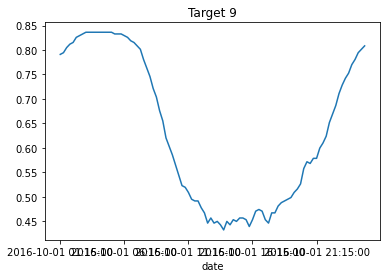

In [222]:
for w in range(5,6):
    seqs_normal[w:w+96][9].plot(title='Target 9')

In [213]:
for w in range(5,10):          
    plot = train.generate()
    fig = plot.get_figure()
    fig.savefig("gen_data/gen_"+str(w)+".png")
    plt.clf()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [218]:
node_f

,total_space,monthly_fee,住宅,公共,写字楼,商业
0,0.200000,0.375000,0,0,1,0
1,0.900000,0.416667,0,0,1,0
2,0.173333,0.750000,0,0,0,1
3,0.266667,0.091667,1,0,0,0
4,0.486667,0.091667,1,0,0,0
5,1.000000,0.250000,0,1,0,0
6,0.600000,0.416667,0,0,1,0
7,0.620000,0.091667,0,0,1,0
8,0.320000,1.000000,0,0,0,1
9,0.386667,0.208333,1,0,0,0
